<a href="https://colab.research.google.com/github/KeyboarderSon/KerasExample/blob/main/BostonHousing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 주택 가격 예측

범죄율, 지방세율 등의 데이터가 주어졌을 때 주택 가격의 중간 값을 예측해보자.

404개의 training set, 102개의 test set으로 구성된 데이터셋이다.<br>
feature은 총 13가지로 1인당 범죄율 주택당 평균 방의 개수, 고속도로 접근성 등이 있다.

In [8]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()


In [9]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


target은 주택의 중간 가격으로 천 달러 단위이다. 일부만 살펴보자.

In [4]:
train_targets[:10]

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4])

### **데이터 전처리**

feature마다 각기 다른 스케일을 가지게 되면 학습이 더 어렵다.

<br>

*특성별로 표준화를 하자!*
$$Z = {X - m \over 	
\sigma}$$

특성의 중앙이 0 근처에 맞춰지고 표준 편차가 1이 된다.  
테스트 데이터를 정규화할 때 사용한 값이 훈련데이터에서 계산한 값이다!  
머신러닝 작업 과정에서 절대로 테스트 데이터에서 계산한 어떤 값도 사용해서는 안된다.

In [10]:
#axis = 0은 row를 기준으로
#각 특성별 표준화

mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

### **모델 구성**

훈련 데이터의 개수가 적을 수록 overfitting이 더 쉽게 일어나니 작은 모델을 사용하자.  
동일한 모델을 여러 번 생성할 것이므로 함수를 만들어 사용해보자.

In [11]:
from keras import models
from keras import layers

def build_model():
  model = models.Sequential()
  model.add(layers.Dense(64, activation = 'relu', input_shape=(train_data.shape[1],)))
  model.add(layers.Dense(64, activation = 'relu'))
  model.add(layers.Dense(1))
  model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
  return model

마지막 층에는 activation function이 없는데 이는 전형적인 스칼라 회귀(하나의 연속적인 값을 예측하는 회귀)를 위한 구성이다. 활성화 함수를 사용하면 출력값에 제한이 생긴다.  
지표 'mae'는 평균 절대 오차로, 예측과 타깃 사이 거리의 절댓값이다.  
예를 들어 이 예제에서 MAE=0.5라면 예측이 평균적으로 500달러 정도 차이 난다는 것이다.

### K-겹 검증을 사용한 훈련 검증

데이터셋 자체가 작은 경우 validation set에 대한 성능평가의 신뢰성이 떨어지게 된다.  
validation set을 어떻게 잡느냐에 따라 성능이 확확 달라지게 되면 이로 인해 모델 평가 지표에 편향이 생긴다.


> K겹 검증 : training data의 모든 데이터가 한 번씩은 validation set으로 쓰이도록 한다!  

이때 모델도 K개가 된다.  

만약 K = 4라면  

| A |  B | C | D |
|----|----|----|----|
|**검증**|훈련|훈련|훈련|
|훈련|**검증**|훈련|훈련|
|훈련|훈련|**검증**|훈련|
|훈련|훈련|훈련|**검증**|

이때, A+B+C+D = Training Set  

모델의 검증 점수는 K개의 검증 점수 평균이 된다.



**K 겹 검증이 어떻게 동작하는지 보여주기 위하여**

In [13]:
import numpy as np


k = 4

num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
  print("처리중인 폴드 #", i)
  val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

  partial_train_data = np.concatenate([train_data[: i * num_val_samples],
                                      train_data[(i+1) * num_val_samples:]])
  
  partial_train_targets = np.concatenate([train_targets[: i * num_val_samples],
                                         train_targets[(i+1) * num_val_samples :]])
  
  # k개의 새로운 모델로!
  model = build_model()
  model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size = 1, verbose = 0)
  val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
  all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


각 모델별로 예측 주택값과의 차이가 이렇게 다르다. 이들의 평균값이 더 신뢰할만 하겠다.

In [14]:
all_scores

[2.257486581802368, 2.7958240509033203, 2.5616376399993896, 2.4411327838897705]

In [15]:
np.mean(all_scores)

2.514020264148712

### Epoch = 500, 로그를 남기며 훈련시켜보자

In [18]:
num_epochs = 500
all_mae_histories = []

for i in range(k):
  print("처리중인 폴드 #", i)
  val_data = train_data[i * num_val_samples : (i+1) * num_val_samples]
  val_targets = train_targets[i * num_val_samples: (i+1) * num_val_samples]

  partial_train_data = np.concatenate([train_data[: i * num_val_samples],
                                      train_data[(i+1) * num_val_samples:]])
  
  partial_train_targets = np.concatenate([train_targets[: i * num_val_samples],
                                         train_targets[(i+1) * num_val_samples :]])
  
  model = build_model()
  history = model.fit(partial_train_data, partial_train_targets, 
            validation_data=(val_data, val_targets),
            epochs = num_epochs, batch_size = 1, verbose = 0)
  mae_history = history.history['val_mae']
  all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


모든 폴드에 대해 epoch의 MAE 점수 평균을 계산한다

In [20]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

**Epoch별 검증 MAE**

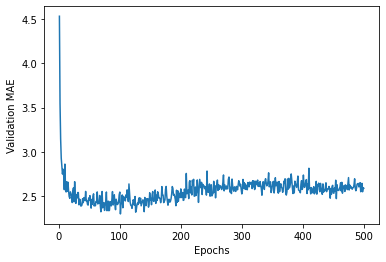

In [24]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history)+1), average_mae_history)

plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

훈련 시작으로부터 대략 10 epoch 까지 범위 변동이 크고 보다 부드러운 곡선을 얻기 위해  
* 첫 10개의 데이터 포인트를 제외시키고
* 지수 이동 평균으로 대체한다.
  이는 시계열 데이터를 부드럽게 만드는 기법 중 하나이다.

**처음 10개의 데이터 포인트를 제외한 검증 MAE 그리기**

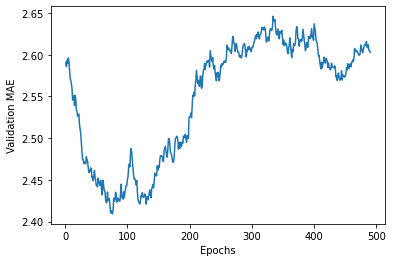

In [25]:
def smooth_curve(points, factor=0.9):
  smoothed_points=[]
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

약 80 epoch 이후에 다시 증가한다. 그 시점 이후로는 오버피팅이 된 것으로 보인다.